<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Performance Monitoring: Fraud Detection</h1>

**Overview**: In this example, we see how to use UpTrain to monitor performance of a fraud classification task. To do this, we will train a binary classifier on a popular network traffic dataset called the [NSL-KDD dataset](https://www.unb.ca/cic/datasets/nsl.html) for cyber-attack classification using the [XGBoost classifier](https://xgboost.readthedocs.io/en/stable/). 

**Dataset**: The NSL-KDD dataset includes a variety of network attack types, including denial-of-service (DoS) attacks, unauthorized access (U2R) attacks, and probe attacks. The dataset contains a total of around 25,000 instances and 41 different features that describe the behavior of network connections, such as the number of failed login attempts and the size of packets transmitted.

**Why is monitoring needed**: Once our fraud detection model has finished training, it may initially perform well in detecting malicious activity. However, over time, attackers may adapt their tactics and evolve their methods, leading to a mismatch between the type of attacks seen during training and those seen in production. This can result in decreased accuracy in our model's predictions.

**Solution**: We will use the UpTrain framework which provides an easy-to-configure way to log model predictions and attach ground-truth to monitor the model's performance. We are using drift detection method on top of the model's performance to raise alerts in case of any dip in the model's accuracy. This kind of data drift that occurs when the statistical properties of the target variable changes is commonly called **Concept Drift.**

### Install required packages for this example [XGBoost]

In [1]:
# !pip install xgboost streamlit

#### Let's first import all the required packages

In [ ]:
import uptrain.v0 as uptrain
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from helper_funcs import download_dataset, pretty

## Step 1: Let's download and prepare the NSL-KDD dataset

In [3]:
s3_url = "https://oodles-dev-training-data.s3.amazonaws.com"
data_file = "NSL_KDD_binary.csv"
download_dataset(s3_url, data_file)

Data file exists. Skipping download.
NSL_KDD_binary.csv dataset prepared successfully!


#### Let's read the data and see how it looks

In [4]:
df = pd.read_csv(data_file)
print("Labels for first few rows:")
print(list(df['label'].head()), "\n")
print("Input features for first few rows:")
df.drop("label", axis=1).head()

Labels for first few rows:
[0, 0, 1, 0, 0] 

Input features for first few rows:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,20,9,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,2,44,9,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,1,49,5,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,1,24,9,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,1,24,9,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Divide the data into training and test sets
We use first 10% of the data to train and 90% of the data to evaluate the model in production

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1].values, df.iloc[:, -1].values,
                                                    test_size = 0.9, 
                                                    random_state = 0,
                                                    shuffle=False)

print("Num Training samples: ", str(len(X_train)) + ",", " Num Testing samples: ", len(X_test))

Num Training samples:  14851,  Num Testing samples:  133666


## Step 2: Train our XGBoost Classifier

In [6]:
# Train the XGBoost classifier with training data
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_train)
print("Training accuracy: " + str(100*accuracy_score(y_train, y_pred)))

Training accuracy: 100.0


Woah! 😲🔥 The training accuracy is 100%. Let's see how long the model lasts in production. 

## Step 3: Monitoring model performance using UpTrain

In [15]:
checks = [
    {
        "type": uptrain.Monitor.CONCEPT_DRIFT,
        "algorithm": uptrain.DataDriftAlgo.DDM
    },
    {
        "type": uptrain.Monitor.CONCEPT_DRIFT,
        "algorithm": uptrain.DataDriftAlgo.ADWIN,
        "measurable_args": {
            "type": uptrain.MeasurableType.MAE
        }
    }
]

cfg = {
    # Checks to identify concept drift
    "checks": checks,
    
    # Folder that stores the drifted data-points identified by UpTrain
    "retraining_folder": 'uptrain_smart_data',
    
    # Enable streamlit logging to visualize model's performance
    "logging_args": {"st_logging": True}
}

pretty(cfg)

- checks:
	- type:
		Monitor.CONCEPT_DRIFT
	- algorithm:
		DataDriftAlgo.DDM
	- type:
		Monitor.CONCEPT_DRIFT
	- algorithm:
		DataDriftAlgo.ADWIN
	- measurable_args:
		- type:
			MeasurableType.MAE
- retraining_folder:
	uptrain_smart_data


If you have not used streamlit before on your system, follow the instructions at https://docs.streamlit.io/library/get-started/installation before running the next cell

In [16]:
# Initialize the UpTrain framework
framework = uptrain.Framework(cfg)

batch_size = 10000
for i in range(int(len(X_test)/batch_size)):
    
    # Do model prediction
    inputs = {"feats": X_test[i*batch_size:(i+1)*batch_size]}
    preds = classifier.predict(inputs["feats"])
    
    # Log model inputs and outputs to monitor concept drift
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Attach ground truth to corresponding predictions 
    # in UpTrain framework and identify concept drift
    ground_truth = y_test[i * batch_size : (i + 1) * batch_size] 
    framework.log(identifiers=ids, gts=ground_truth)
    
    # Pausing between batches to monitor progress in the dashboard
    time.sleep(0.5)

Deleting the folder:  uptrain_smart_data
Deleting the folder:  uptrain_logs
Drift detected with DDM at time: 111296
Drift detected with ADWIN at time: 111455


### From the UpTrain Dashboard

Here is a snippet of the model's performance from the UpTrain dashboard. As you can see, the model's accuracy starts to dip around the timestamp of 111k.

#### Concept Drift detected using DDM

<img width="629" alt="concept_drift_avg_acc" src="https://uptrain-demo.s3.us-west-1.amazonaws.com/fraud_detection/concept_drift_avg_acc.gif">

<br />

#### Concept Drift detected using ADWIN

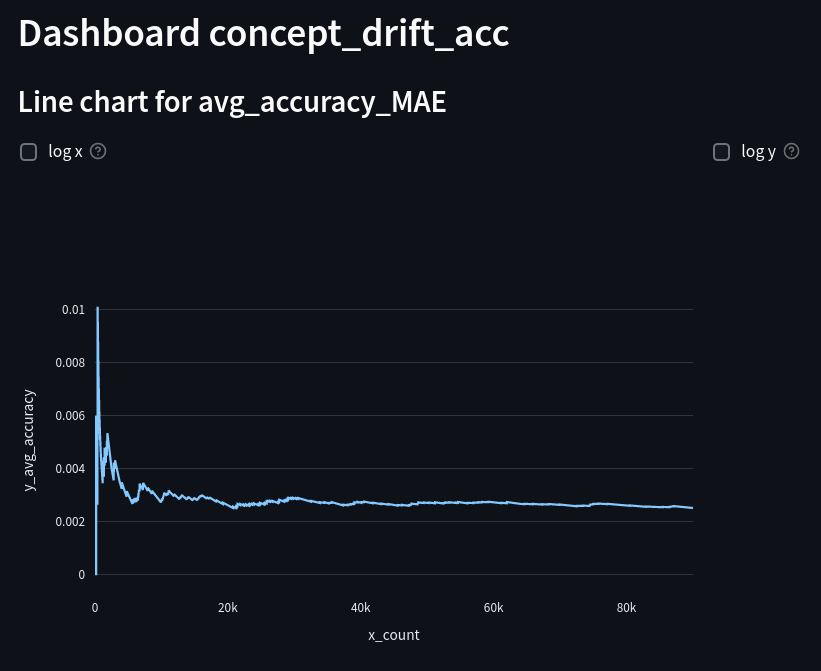

In this example, we used two popular drift detection algorithms called the [Drift Detection Method (DDM)](https://riverml.xyz/0.11.1/api/drift/DDM/)  and [Adaptive Windowing (ADWIN)](https://riverml.xyz/0.15.0/api/drift/ADWIN/) which is already implemented as a part of the UpTrain package. However, as we can see the model accuracy dropped from 99.7% to 96.9%, which is still a slow decline and might not raise many eyebrows. 

For better detection and to understand the severity of the issue, one might want to define a customized metric and monitor the models using them. Let's see how we can do this in UpTrain.

## Step 4: Define a Custom Monitor in UpTrain (for better monitoring)

We now define a custom drift metric which monitors the difference between accuracy of the model in the first 200 predictions and the latest 200 predictions. This way, we can quickly identify if there is a sudden degradation in the model's performance.

Let's define our custom check and UpTrain config with check as "Custom Monitor" as below:

In [9]:
# Defining a custom drift metric to check if accuracy drops beyond a threshold.

def custom_initialize_func(self) -> None:
    self.initial_acc = None       
    self.acc_arr = []
    self.count = 0       
    self.thres = 0.02
    self.window_size = 200
    self.is_drift_detected = False

def custom_check_func(self, inputs, outputs, gts=None, extra_args={}) -> None:
    batch_size = len(extra_args["id"])
    self.count += batch_size
    self.acc_arr.extend(list(np.equal(gts, outputs)))
    
    # Calculate initial performance of the model on first 200 points
    if (self.count >= self.window_size) and (self.initial_acc is None):
        self.initial_acc = sum(self.acc_arr[0:self.window_size])/self.window_size
        
    # Calculate the most recent accuracy and log it to dashboard.
    if (self.initial_acc is not None):
        for i in range(self.count - batch_size, self.count, self.window_size):
            
            # Calculate the most recent accuracy
            recent_acc = sum(self.acc_arr[i:i+self.window_size])/self.window_size
            
            # Logging to UpTrain dashboard
            self.log_handler.add_scalars('custom_metrics', 
                    {'y_acc': self.initial_acc},
                i, self.dashboard_name, file_name='initial_acc')
            self.log_handler.add_scalars('custom_metrics', 
                    {'y_acc': recent_acc, },
                i, self.dashboard_name, file_name='recent_acc')
            
            # Send an alert when recent model performance goes down 
            if (self.initial_acc - recent_acc > self.thres) and (not self.is_drift_detected):
                alert = f"Concept drift detected with custom metric at time: {i}!!!" 
                print(alert)
                self.log_handler.add_alert(
                    "Model Performance Degradation Alert 🚨",
                    alert,
                    self.dashboard_name
                )
                self.is_drift_detected = True

In [10]:
checks.append({
    "type": uptrain.Monitor.CUSTOM_MONITOR,
    "initialize_func": custom_initialize_func,
    "check_func": custom_check_func,
    "need_gt": True
})

In [11]:
cfg = {
    "checks": checks,
    
    # Folder that stores the drifted data-points identified by UpTrain
    "retraining_folder": 'uptrain_smart_data',
    
    # Enable streamlit logging to visualize model's performance
    "logging_args": {"st_logging": True}
}

pretty(cfg)

- checks:
	- type:
		Monitor.CONCEPT_DRIFT
	- algorithm:
		DataDriftAlgo.DDM
	- type:
		Monitor.CONCEPT_DRIFT
	- algorithm:
		DataDriftAlgo.ADWIN
	- measurable_args:
		- type:
			MeasurableType.MAE
	- type:
		Monitor.CUSTOM_MONITOR
	- initialize_func:
		<function custom_initialize_func at 0x7fdd930ad630>
	- check_func:
		<function custom_check_func at 0x7fdd930ad480>
	- need_gt:
		True
- retraining_folder:
	uptrain_smart_data


In [12]:
# Initialize the UpTrain framework
framework = uptrain.Framework(cfg)

batch_size = 10000
for i in range(int(len(X_test)/batch_size)):
    
    # Do model prediction
    inputs = {"feats": X_test[i*batch_size:(i+1)*batch_size]}
    preds = classifier.predict(inputs["feats"])
    
    # Log model inputs and outputs to monitor concept drift
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Attach ground truth to corresponding predictions 
    # in UpTrain framework and identify concept drift
    ground_truth = y_test[i * batch_size : (i + 1) * batch_size] 
    framework.log(identifiers=ids, gts=ground_truth)
    
    # Pausing between batches to monitor progress in the dashboard
    time.sleep(0.5)

Deleting the folder:  uptrain_smart_data
Drift detected with DDM at time: 111296
Drift detected with ADWIN at time: 111455
Concept drift detected with custom metric at time: 111000!!!


### From the UpTrain Dashboard

After using our custom monitors, we see a sudden and more alarming drop in the model accuracy. It drops from 99.7% to 77%. Being able to detect this drop early enables us to send better alerts and take more urgent measures (ex: model retraining) to resolve them. 

<img width="624" alt="concept_drift_custom" src="https://uptrain-demo.s3.us-west-1.amazonaws.com/fraud_detection/custom_measure.gif">

## Conclusion

Model monitoring is crucial for tasks such as fraud detection, cyber-security attacks etc. where the malicious agents continuously improve their attack vectors and with time, learn to evade detection. Real-time model observability enables one to proactively address any performance degradation before it leads to serious consequences, such as data breaches or financial losses.

In this example, we saw two ways to detect performance degradation - Concept Drift via DDM and Custom Monitor. The UpTrain framework has many other statistical tools, such as data drift, integrity checks, shift in model outputs, and outlier detection, that can be used to identify model issues, even in cases where ground truth is not available. You can explore them [here](https://github.com/uptrain-ai/uptrain/tree/main/examples)

- Automatically detecting edge-cases and out-of-distribution samples - [Link](https://github.com/uptrain-ai/uptrain/blob/main/examples/human_orientation_classification/run.ipynb)
- Defining custom signals to identify edge-cases - [Link](https://github.com/uptrain-ai/uptrain/blob/main/examples/human_orientation_classification/deepdive_examples/uptrain_edge_cases_torch.ipynb)
- Using Data-Drift (i.e. shifts in input distribution) to identify dips in model performance - [Link](https://github.com/uptrain-ai/uptrain/blob/main/examples/1_orientation_classification/deepdive_examples/uptrain_data_drift_custom_measures.ipynb)
- Monitoring bias in recommendation systems - [Link](https://github.com/uptrain-ai/uptrain/blob/main/examples/shopping_cart_recommendation/run.ipynb)
